In [389]:
# importing required packages and libraries
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as img
from gettext import install
from PIL import Image
import pywt
import os
import re
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

In [390]:
# loading the datatset
df = pd.read_excel('height_and_pose.xlsx')
df.head()

,Depthmap Image,Height(cm),Pose
0,1d5fee00-ada4-11eb-a80b-3f50af21830f,76.7,"[{'bbox_coordinates': [(158.91087, 92.53168), ..."
1,1eddf4c0-ad9f-11eb-a80b-ef4adba049aa,66.4,"[{'bbox_coordinates': [(131.00702, 68.115364),..."
2,38e29bc0-8fc0-11eb-b5f2-0742da91b282,63.2,"[{'bbox_coordinates': [(116.070114, 37.567608)..."
3,6cd5d480-8b8b-11eb-b152-f7b115384fa9,87.1,"[{'bbox_coordinates': [(145.24242, 26.49348), ..."
4,76ed6fc0-8e1d-11eb-ad70-7be1a1219834,59.1,"[{'bbox_coordinates': [(150.17046, 65.00379), ..."


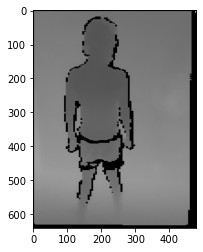

In [391]:
#loading images
x,y = [],[]
path = r"C:\Users\madhu\Dropbox\My PC (LAPTOP-9DI2D1AT)\Downloads\DS_Assignment 2\DS_Assignment 2\depthmap"
for i in range(len(df)):
    for file in os.listdir(path):
        if file.startswith(df['Depthmap Image'][i]):   
                img = cv2.imread(os.path.join(path,file))
                scalled_raw_img = cv2.resize(img, (32, 32))
                x.append(scalled_raw_img) 
                y.append(df['Height(cm)'][0])

                    
plt.imshow(img) 

In [392]:
x[0]

array([[[  0,   0,   0],
        [ 88,  88,  88],
        [ 87,  87,  87],
        ...,
        [ 84,  84,  84],
        [ 83,  83,  83],
        [ 84,  84,  84]],

       [[  0,   0,   0],
        [ 90,  90,  90],
        [ 90,  90,  90],
        ...,
        [ 85,  85,  85],
        [ 85,  85,  85],
        [ 85,  85,  85]],

       [[  0,   0,   0],
        [ 90,  90,  90],
        [ 90,  90,  90],
        ...,
        [ 85,  85,  85],
        [ 85,  85,  85],
        [ 86,  86,  86]],

       ...,

       [[  0,   0,   0],
        [114, 114, 114],
        [114, 114, 114],
        ...,
        [106, 106, 106],
        [107, 107, 107],
        [107, 107, 107]],

       [[  0,   0,   0],
        [118, 118, 118],
        [117, 117, 117],
        ...,
        [108, 108, 108],
        [109, 109, 109],
        [109, 109, 109]],

       [[  0,   0,   0],
        [120, 120, 120],
        [118, 118, 118],
        ...,
        [109, 109, 109],
        [110, 110, 110],
        [110, 110, 110]]

In [393]:
x = np.asarray(x)
y = np.asarray(y)

In [394]:
#flattening the images
X = np.array(x).reshape(len(x),32*32*3).astype(float)
X.shape

(9, 3072)

In [395]:
#first using SVR for prediction
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [396]:
pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel = 'rbf', C = 10))])
pipe.fit(x_train, y_train)
pipe.score(x_test, y_test)#score recieved is 1 (highest)

1.0

In [397]:
#using Neural network for prediction
nn1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(1)
])
nn1.compile(loss=tf.keras.losses.mae, #mean absolute error as loss
                optimizer=tf.keras.optimizers.Adam(),# Adam as optimizer
                metrics=['mae'])
nn1.fit(x_train, y_train, epochs=100, verbose=0)

In [398]:
nn1.evaluate(x_test,y_test) #errr is around 10

1/1 [==============================] - 0s 94ms/step - loss: 8.8429 - mae: 8.8429


[8.84289836883545, 8.84289836883545]

In [399]:
nn2 = tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(1)
])
nn2.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.SGD(),# SGD as optimizer
                metrics=['mae'])
nn2.fit(x_train, y_train, epochs=100, verbose=0)

In [400]:
nn2.evaluate(x_test,y_test) # error is huge, hence Adam is way better than SGD for our problem

1/1 [==============================] - 0s 94ms/step - loss: 75.7400 - mae: 75.7400


[75.73999786376953, 75.73999786376953]

In [401]:
# using Convolutional Neural Network for prediction
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)
cnn = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation=tf.keras.activations.relu,input_shape=(32,32,3)),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation=tf.keras.activations.relu),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(1)
])
cnn.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])
cnn.fit(x_train, y_train, epochs=100, verbose=0)

In [402]:
cnn.evaluate(x_test,y_test) #error is around 10

1/1 [==============================] - 0s 133ms/step - loss: 11.5505 - mae: 11.5505


[11.55046558380127, 11.55046558380127]

In [403]:
# using KNN for prediction
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

x_train = scaler.fit_transform(x_train)

x_test = scaler.fit_transform(x_test)



In [404]:
rmse_val = [] #to store rmse values for different k
for K in range(5):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)


RMSE value for k=  1 is: 0.0
RMSE value for k=  2 is: 0.0
RMSE value for k=  3 is: 0.0
RMSE value for k=  4 is: 0.0
RMSE value for k=  5 is: 0.0
